We want to show that accuracy increases on SpatialSenses when pretrained on STUPD

# Training on spatial senses only

## Data

In [1]:
import torch
from torch.utils.data import Dataset
from torch import nn
import torch.nn.functional as F

from fastai.distributed import *
from fastai.vision.all import *

from pathlib import Path
from functools import partial
import json
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
device = torch.device('cuda:0')
core_pth = Path('/home/agrawalp2/prepositions'); assert core_pth.exists()
spatialSenses_pth = core_pth/Path('real_world_data/spatialsense'); assert spatialSenses_pth.exists()
stupd_pth = Path('/mnt/dataset/agrawalp2/stupd_dataset'); assert stupd_pth.exists()

In [3]:
#utils
from gensim.models import KeyedVectors
import numpy as np
from autocorrect import Speller

encoder_path = spatialSenses_pth/Path('baselines/GoogleNews-vectors-negative300.bin.gz')
assert encoder_path.exists()
word2vec = KeyedVectors.load_word2vec_format(encoder_path, binary=True, unicode_errors="ignore")

spell = Speller()
def phrase2vec(phrase, max_phrase_len, word_embedding_dim):
    vec = np.zeros((max_phrase_len, word_embedding_dim,), dtype=np.float32)
    for i, word in enumerate(phrase.split()[:max_phrase_len]):
        if word in word2vec: vec[i] = word2vec[word]
        elif spell(word) in word2vec: vec[i] = word2vec[spell(word)]
        else: pass
    return vec

spatialsenses_to_stupd = {
    "above": "above",
    "behind": "behind",
    "in": "inside",
    "in front of": "in_front_of",
    "next to": "beside",
    "on": "on",
    "to the left of": "beside",
    "to the right of": "beside",
    "under": "below",
}

def map_spatialsenses_to_stupd(o, mapping_dict = spatialsenses_to_stupd):
    return spatialsenses_to_stupd[o]

def noop(x): return x

In [4]:
class SpatialDataset(Dataset):
    def __init__(self, split=None, 
                 annotations_path = spatialSenses_pth/'annotations.json', 
                 x_tfms: list = None,
                 y_tfms: list = None):
        
        super().__init__()
        self.subjects = [] #x1
        self.objects = [] #x2
        self.predicates = [] #y
        
        
        self.split = split
        if self.split is not None: assert split in ['train', 'valid', 'test'], f"invalid selection of split. expected values = 'train', 'valid', 'test'"
        
        self.classes = list(set(spatialsenses_to_stupd.values()))
        self.class2idx = {cat:i for i,cat in enumerate(self.classes)}
        self.idx2class = {self.class2idx[cat]:cat for cat in self.class2idx}
        self.c = len(self.classes)
        
        self.x_tfms = list(x_tfms or [noop]) 
        self.y_tfms = list(y_tfms or [noop]) + [lambda y: self.class2idx[y]]
        
        for relations in json.load(open(annotations_path)):
            if self.split and not relations["split"] == split: continue
            for relation in relations['annotations']:
                if not relation['label']: continue
                self.subjects.append(relation['subject']['name'])
                self.objects.append(relation['object']['name'])
                self.predicates.append(relation['predicate'])
    
    def __len__(self): return len(self.subjects)
    def __getitem__(self, i):
        subj = self.apply_tfms(self.subjects[i], self.x_tfms)
        obj =  self.apply_tfms(self.objects[i] , self.x_tfms)
        predicate = self.apply_tfms(self.predicates[i], self.y_tfms)
        
        return (torch.Tensor(subj).type(torch.cuda.FloatTensor), 
                torch.Tensor(obj).type(torch.cuda.FloatTensor), 
                torch.Tensor([predicate]).type(torch.cuda.LongTensor))

    def apply_tfms(self, o, tfms):
        for tfm in tfms: o = tfm(o)
        return o

In [5]:
max_phrase_len = 2 #subjects/objects can be mutliple words. eg - microwave oven. max_phrase_len decides how many words are used to create embeddings
word_embedding_dim = 300 #decides the dimension of the feature each word is converted into

embedding = partial(phrase2vec, max_phrase_len = max_phrase_len, word_embedding_dim = word_embedding_dim)

train_ds = SpatialDataset(split = 'train',
                         x_tfms = [embedding],
                         y_tfms = [map_spatialsenses_to_stupd])

valid_ds = SpatialDataset(split = 'valid',
                         x_tfms = [embedding],
                         y_tfms = [map_spatialsenses_to_stupd])

len(train_ds),len(valid_ds)

(5619, 1319)

In [6]:
train_dl = DataLoader(train_ds, batch_size =64 , shuffle = True, drop_last = True)
valid_dl = DataLoader(valid_ds, batch_size = 128 , shuffle = True, drop_last = True)

## Model

In [7]:
class LinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim, bn=True, relu=True):
        super().__init__()
        
        self.bn = bn
        self.relu = relu
        
        self.linear = nn.Linear(input_dim, output_dim)
        self.batchnorm = nn.BatchNorm1d(output_dim)
        self.ReLU = nn.ReLU()
        
    def forward(self, x):
        x = self.linear(x)
        if self.bn: x = self.batchnorm(x)
        if self.relu: x = self.ReLU(x)
        return x
    
    
class SimpleLanguageOnlyModel(nn.Module):
    def __init__(self, word_embedding_dim, feature_dim, c):
        super().__init__()
        self.phrase_encoder = nn.GRU(input_size = word_embedding_dim, 
                                     hidden_size = word_embedding_dim//2,
                                     num_layers = 1,
                                     batch_first = True,
                                     bidirectional = True,
                                    )

        self.linear1 = LinearBlock(word_embedding_dim, feature_dim)
        self.linear2 = LinearBlock(word_embedding_dim, feature_dim)
        self.linear3 = LinearBlock(2*feature_dim, feature_dim)
        self.linear4 = nn.Linear(feature_dim, c)
        
    def forward(self, subj, obj):
        subj = torch.squeeze(self.phrase_encoder(subj)[0][:,-1,:])
        obj = torch.squeeze(self.phrase_encoder(obj)[0][:,-1,:])
        
        subj = self.linear1(subj)
        obj  = self.linear2(obj)
        
        x = torch.cat((subj,obj), dim = 1)
        x = self.linear4(self.linear3(x))
        return x

## training

In [8]:
dls = DataLoaders(train_dl, valid_dl)
dls.n_inp = 2
model = SimpleLanguageOnlyModel(word_embedding_dim, 512, train_ds.c).cuda()
learn = Learner(dls, model = model, loss_func = CrossEntropyLossFlat(), metrics = [accuracy,BalancedAccuracy()])

In [9]:
learn.fit(10, 1e-4)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.640934,1.563597,0.430469,0.310204,00:01
1,1.445088,1.538120,0.438281,0.323340,00:01
2,1.310785,1.531476,0.440625,0.341141,00:01
3,1.210801,1.536500,0.454688,0.354403,00:01
4,1.142441,1.538174,0.449219,0.357084,00:01
5,1.068168,1.577274,0.449219,0.366287,00:01
6,1.015014,1.598668,0.453125,0.363494,00:01
7,0.964645,1.620634,0.432031,0.356796,00:01
8,0.917249,1.651161,0.446094,0.362350,00:01
9,0.869659,1.690896,0.432813,0.356942,00:01


# Pretraining on STUPD

In [10]:
class stupd(Dataset):
    def __init__(self,
                 annotations_path = stupd_pth/'annotations', 
                 x_tfms: list = None,
                 y_tfms: list = None):
        
        super().__init__()
        self.subjects = [] #x1
        self.objects = [] #x2
        self.predicates = [] #y
        
        
#         self.split = split
#         if self.split is not None: assert split in ['train', 'valid', 'test'], f"invalid selection of split. expected values = 'train', 'valid', 'test'"
        
        self.classes = list(set(spatialsenses_to_stupd.values()))
        self.class2idx = {cat:i for i,cat in enumerate(self.classes)}
        self.idx2class = {self.class2idx[cat]:cat for cat in self.class2idx}
        self.c = len(self.classes)
        
        self.x_tfms = list(x_tfms or [noop]) 
        self.y_tfms = list(y_tfms or [noop]) + [lambda y: self.class2idx[y]]
        
#         for relations in json.load(open(annotations_path)):
#             if self.split and not relations["split"] == split: continue
#             for relation in relations['annotations']:
#                 if not relation['label']: continue
#                 self.subjects.append(relation['subject']['name'])
#                 self.objects.append(relation['object']['name'])
#                 self.predicates.append(relation['predicate'])
        for annotations in annotations_path.iterdir():
            
            if annotations.stem not in spatialsenses_to_stupd.values(): continue
            df = pd.read_csv(annotations).dropna()
            for i,row in df.iterrows():
#                 print(row['subject_category'], math.isnan(row['subject_category']))
#                 if not row['subject_category'] or not row['object_category']: continue
                self.subjects.append(row['subject_category'] + ' ' + row['subject_supercategory'])
                self.objects.append(row['object_category'] + ' ' + row['object_supercategory'])
                self.predicates.append(annotations.stem)
                
    
    def __len__(self): return len(self.subjects)
    
    def __getitem__(self, i):
        subj = self.apply_tfms(self.subjects[i], self.x_tfms)
        obj =  self.apply_tfms(self.objects[i] , self.x_tfms)
        predicate = self.apply_tfms(self.predicates[i], self.y_tfms)
        
        return (torch.Tensor(subj).type(torch.cuda.FloatTensor), 
                torch.Tensor(obj).type(torch.cuda.FloatTensor), 
                torch.Tensor([predicate]).type(torch.cuda.LongTensor))

    def apply_tfms(self, o, tfms):
        for tfm in tfms: o = tfm(o)
        return o

In [11]:
max_phrase_len = 3 #subjects/objects can be mutliple words. eg - microwave oven. max_phrase_len decides how many words are used to create embeddings
word_embedding_dim = 300 #decides the dimension of the feature each word is converted into

embedding = partial(phrase2vec, max_phrase_len = max_phrase_len, word_embedding_dim = word_embedding_dim)

ds = stupd(x_tfms = [embedding],
                 y_tfms = None)

len(ds)

34313

In [12]:
train_split = 0.8
train_ds, valid_ds = torch.utils.data.random_split(ds, [int(len(ds)*train_split), len(ds) - int(len(ds)*train_split)])
train_ds.c, valid_ds.c = 7,7

len(train_ds), len(valid_ds)

(27450, 6863)

In [13]:
train_dl = DataLoader(train_ds, batch_size =64 , shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = 128 , shuffle = False)

In [14]:
dls = DataLoaders(train_dl, valid_dl)
dls.n_inp = 2
model = SimpleLanguageOnlyModel(word_embedding_dim, 512, train_ds.c).cuda()
learn = Learner(dls, model = model, loss_func = CrossEntropyLossFlat(), metrics = [accuracy,BalancedAccuracy()])

SuggestedLRs(valley=0.0004786300996784121)

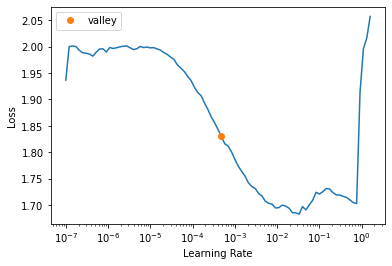

In [15]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.392758,1.353980,0.364855,0.363772,00:06
1,1.334508,1.316863,0.386420,0.385081,00:06
2,1.316514,1.309077,0.387877,0.385560,00:06
3,1.312311,1.298863,0.391083,0.388087,00:06
4,1.309101,1.293413,0.391957,0.388772,00:06
5,1.304109,1.289163,0.393851,0.391761,00:06
6,1.296915,1.287882,0.392977,0.391397,00:06
7,1.286490,1.283885,0.399534,0.397290,00:06
8,1.282871,1.282739,0.401719,0.399603,00:06
9,1.281986,1.282832,0.403905,0.401537,00:06


### Now transfer learning

In [17]:
max_phrase_len = 2 #subjects/objects can be mutliple words. eg - microwave oven. max_phrase_len decides how many words are used to create embeddings
word_embedding_dim = 300 #decides the dimension of the feature each word is converted into

embedding = partial(phrase2vec, max_phrase_len = max_phrase_len, word_embedding_dim = word_embedding_dim)

train_ds_spatialsenses = SpatialDataset(split = 'train',
                         x_tfms = [embedding],
                         y_tfms = [map_spatialsenses_to_stupd])

valid_ds_spatialsenses = SpatialDataset(split = 'valid',
                         x_tfms = [embedding],
                         y_tfms = [map_spatialsenses_to_stupd])

len(train_ds_spatialsenses),len(valid_ds_spatialsenses)

(5619, 1319)

In [18]:
train_dl_spatialsenses = DataLoader(train_ds_spatialsenses, batch_size =64 , shuffle = True)
valid_dl_spatialsenses = DataLoader(valid_ds_spatialsenses, batch_size = 128 , shuffle = False)

In [19]:
learn = Learner(dls, model = model, loss_func = CrossEntropyLossFlat(), metrics = [accuracy,BalancedAccuracy()])
# learn.freeze_to(-2)

SuggestedLRs(valley=9.120108734350652e-05)

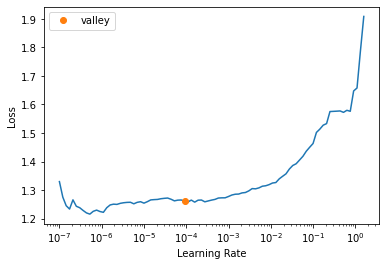

In [20]:
learn.lr_find()

In [21]:
learn.fit_one_cycle(10, 1e-5)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.280499,1.282566,0.402448,0.400207,00:06
1,1.281304,1.282712,0.400699,0.398453,00:06
2,1.292095,1.283208,0.400991,0.398461,00:06
3,1.274830,1.283049,0.402302,0.399618,00:06
4,1.276200,1.282363,0.400117,0.397474,00:06
5,1.269681,1.282304,0.400845,0.398345,00:06
6,1.283493,1.282483,0.398951,0.396930,00:06
7,1.279635,1.282291,0.398077,0.395390,00:06
8,1.277481,1.281887,0.397785,0.395027,00:06
9,1.268634,1.282565,0.399825,0.397856,00:06
